### Imports

In [1]:
import re
import os, sys
import subprocess
import time

import language_tool_python
from sqlalchemy import text

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from pathlib import Path

from scipy import stats
from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\chris\AppData\Local\Temp\ipykernel_19568\2634739465.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Add project to path

In [2]:
current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from src.database.database import engine

### Preprocess Pipeline

In [ ]:
def unmark_element(markdown_text: str) -> str:
    """
    Cleans and strips markdown content, leaving behind only the semantic text
    ready for an embedding model.

    Args:
        markdown_text: The raw markdown string.

    Returns:
        A cleaned text string.
    """

    # --- 1. Initial Cleaning and Normalization ---

    # 1.1 REMOVE LINKS AND IMAGE TAGS: Remove the pattern [text](url) and ![text](url)
    text = re.sub(r'\!?\[.*?\]\s*\(.*?\)', '', markdown_text, flags=re.DOTALL)
    text = re.sub(r'Zoom image will be displayed', '', text)
    text = re.sub(r'http[s]?://miro.medium.com/v2/resize:.*?\.png', '', text)

    # 1.2 Remove Extraneous Backslashes (e.g., escaping in \- or \.)
    text = re.sub(r'\\-', '-', text)
    text = re.sub(r'\\([`*_{}\[\]()#+.!])', r'\1', text)
    
    # 1.3 Normalize Newlines: Convert multiple newlines/whitespace into a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # --- 2. Markdown Structure Stripping ---

    # 2.1 Remove Headings (Setext style: === or --- lines)
    text = re.sub(r'\n[=-]{2,}\s*$', '', text, flags=re.MULTILINE)

    # 2.2 Remove Blockquotes/Code Fences (Markers: > and ```)
    text = re.sub(r'^\s*>\s?', '', text, flags=re.MULTILINE)
    text = re.sub(r'```[a-zA-Z]*\s*', ' ', text)
    text = re.sub(r'`', ' ', text)
    
    # 2.3 Remove List Markers (e.g., 1. or - or *)
    text = re.sub(r'^\s*\d+\.\s', '', text, flags=re.MULTILINE)
    text = re.sub(r'^\s*[\-\*]\s', '', text, flags=re.MULTILINE)
    
    # 2.4 Remove Emphasis Markers (e.g., **, *, __, _)
    text = re.sub(r'(\*\*|__)', '', text) # Bold/Strong
    text = re.sub(r'(\*|_)', '', text)    # Italic/Emphasis

    # 2.5 Remove remaining HTML tags (like '<hibernate-mapping>') which are often in code
    text = re.sub(r'<[^>]+>', '', text)
    
    # --- 3. Final Text Polishing ---

    # 3.1 Normalize Whitespace again: Collapse all multiple spaces into one
    text = re.sub(r'\s+', ' ', text).strip()

    # 3.2 Lowercasing (Optional but recommended for many embedding models)
    text = text.lower()

    return text

def remove_image_errors(text):
    """Remove image links from Markdown text."""
    return text.replace("Press enter or click to view image in full size.", "").strip()



### Setup languagetool server (optional)

In [ ]:
# Set this to true if you want to run a local LanguageTool server
# https://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip
local_server = False
language_tool_path = r"C:\Path\To\LanguageTool\languagetool-server.jar"

In [ ]:
if local_server:
	try:
		# Start LanguageTool server
		lt_process = subprocess.Popen(
			['cmd', '/c', 'start', '', language_tool_path],
			stdout=subprocess.PIPE,
			stderr=subprocess.PIPE
		)
		time.sleep(5)  # Wait for server to start
		lt_server = 'http://localhost:8081'
	except Exception as e:
		print(f"Error starting LanguageTool server: {e}")
		print(f"Download it from\nhttps://internal1.languagetool.org/snapshots/LanguageTool-latest-snapshot.zip")
		lt_server = None
else:
	lt_server = None

### Detect grammatical errors

In [ ]:
LANGUAGE_TOOL = language_tool_python.LanguageTool("en-US", remote_server=lt_server)

def analyze_text(text, tool=LANGUAGE_TOOL):

    def ignore_spelling_mistakes(rule):
        return rule.message == "Possible spelling mistake found."

    def disable_rule_code_in_text(rule):
        disabled_code_in_text_rules = {
                "LC_AFTER_PERIOD",
                "CAPITALIZATION",
                "CAPITALIZATION_NNP_DERIVED",
                "COMMA_PERIOD_CONFUSION",
                "COMMA_PERIOD",
                "DOUBLE_PUNCTUATION",
                "ELLIPSIS",
                "MISSING_HYPHEN",
                "APOSTROPHE_IN_DATES",
                "APOSTROPHE_PLURAL_",
                "WORD_CONTAINS_UNDERSCORE",
                "NON_STANDARD_WORD",
                "NON_STANDARD_ALPHABETIC_CHARACTERS",
                "NON_ENGLISH_CHARACTER_IN_A_WORD",
                "UNICODE_CASING",
                "ID_CASING",
                "SPACE_BEFORE_PARENTHESIS",
                "CONSECUTIVE_SPACES",
                "SPACE_BETWEEN_NUMBER_AND_WORD",
                "UNIT_SPACE",
                "CURRENCY_SPACE",
                "HYPHEN_TO_EN",
                "HYPHEN_TO_EM_OR_COMMA",
                "TWO_HYPHENS",
                "NON_STANDARD_COMMA",
                "SENT_START_NUM",
                "SENT_START_CONJUNCTION",
                "EN_QUOTES",
                "TYPOGRAPHICAL_APOSTROPHE",
                "DOUBLE_APOSTROPHE",
                "APOSTROPHE_VS_QUOTE",
                "GERMAN_QUOTES",
                "OXFORD_COMMA_CASING",
                "SERIAL_COMMA_OFF",
                "SERIAL_COMMA_ON",
                "EN_SPLIT_WORDS_HYPHEN",
                "SENTENCE_FRAGMENT",
                "AI_EN_LECTOR_MISSING_PUNCTUATION",
            }
        return rule.ruleId in disabled_code_in_text_rules

    with tool:
        matches = tool.check(text)

    filters = [ignore_spelling_mistakes, disable_rule_code_in_text]

    filtered = [rule for rule in matches if not any(f(rule) for f in filters)]
    grammar_count = len(filtered)

    # Count per category
    grammar_category_counts = {}
    for match in filtered:
        cat = match.category or "Unknown"
        grammar_category_counts[cat] = grammar_category_counts.get(cat, 0) + 1

    return {
        "grammar_count": grammar_count,
        "grammar_category_counts": grammar_category_counts
    }, True

In [ ]:
df = pd.read_sql("SELECT * FROM medium_articles LIMIT 5", engine)
tqdm.pandas(desc="Processing articles with grammar analysis")

def process_text(full_text):
	unmarked = unmark_element(full_text)
	result, success = analyze_text(unmarked)
	if success:
		return result
	else:
		return None
	
results_series = df['full_article_text'].progress_apply(process_text)
failed_mask = results_series.isna()
failed = df[failed_mask]['full_article_text'].tolist()
print(f"Processed {len(df)} articles, {len(failed)} failed.")

successful_results_df = results_series.dropna().apply(pd.Series)

df_with_grammar = df.join(successful_results_df)
df_with_grammar.to_pickle(r".\grammar_analysis\medium_articles_with_grammar_analysis.pkl")

### Analyze grammatical errors

In [ ]:
df_path = r".\grammar_analysis\medium_articles_with_grammar_analysis.pkl"
df = pd.read_pickle(df_path)
print("Processed articles:",len(df[df['grammar_count'].notna()]))
print("Failed articles:",len(df[df['grammar_count'].isna()]))
print("Columns in DataFrame:")
print(df.columns)

Processed articles: 29336
Failed articles: 0
Columns in DataFrame:
Index(['id', 'url_id', 'title', 'author_id', 'date_published', 'date_modified',
       'date_created', 'description', 'publisher_type', 'is_free', 'claps',
       'comments_count', 'full_article_text', 'read_time', 'type', 'tags',
       'num_images', 'language', 'text_length', 'word_approach_scores',
       'sentence_approach_scores', 'average_approach_scores',
       'average_ai_score', 'grammar_count', 'STYLE', 'REPETITIONS_STYLE',
       'NONSTANDARD_PHRASES', 'BRITISH_ENGLISH', 'TYPOGRAPHY', 'CASING',
       'TYPOS', 'GRAMMAR', 'COLLOCATIONS', 'PROPER_NOUNS', 'CONFUSED_WORDS',
       'COMPOUNDING', 'SEMANTICS', 'PUNCTUATION', 'MISC',
       'MULTITOKEN_SPELLING', 'REDUNDANCY', 'AMERICAN_ENGLISH_STYLE'],
      dtype='object')


In [4]:
df_with_grammar = df.copy()
df_with_grammar = df_with_grammar[df_with_grammar['text_length'] > 0]

free_posts = df_with_grammar[df_with_grammar['is_free'] == True]
paid_posts = df_with_grammar[df_with_grammar['is_free'] == False]
min_size = min(len(free_posts), len(paid_posts))
print(f"Using sample size of {min_size} for both groups.")

free_sample = free_posts.sample(min_size, random_state=42)
paid_sample = paid_posts.sample(min_size, random_state=42)
free_grammar = free_sample['grammar_count']
paid_grammar = paid_sample['grammar_count']

t_stat, p_value = ttest_ind(free_grammar, paid_grammar, equal_var=False)
print(f"\nT-test between Free and Paid articles for grammar_count:")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4e}")

Using sample size of 14667 for both groups.

T-test between Free and Paid articles for grammar_count:
T-statistic: 9.9968, P-value: 1.7377e-23


In [5]:
def cohens_d(x, y):
    n1 = len(x); n2 = len(y)
    m1 = np.mean(x); m2 = np.mean(y)
    s1 = np.std(x, ddof=1); s2 = np.std(y, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    d = (m1 - m2) / s_pooled
    return d, m1, m2, s1, s2, s_pooled

def hedges_g(d, n1, n2):
    df = n1 + n2 - 2
    J = 1 - (3 / (4 * df - 1))
    return d * J

def cohens_d_ci_approx(d, n1, n2, alpha=0.05):
    var_d = (n1 + n2) / (n1 * n2) + (d**2) / (2 * (n1 + n2))
    se = np.sqrt(var_d)
    z = stats.norm.ppf(1 - alpha/2)
    lower = d - z * se
    upper = d + z * se
    return lower, upper, se

# compute
d, m1, m2, s1, s2, s_pooled = cohens_d(free_grammar.values, paid_grammar.values)
g = hedges_g(d, len(free_grammar), len(paid_grammar))
ci_lower, ci_upper, se = cohens_d_ci_approx(d, len(free_grammar), len(paid_grammar))

print(f"Cohen's d: {d:.4f}")
print(f"Hedges' g (bias-corrected): {g:.4f}")
print(f"Means -> free: {m1:.4f}, paid: {m2:.4f}")
print(f"SDs   -> free: {s1:.4f}, paid: {s2:.4f}, pooled: {s_pooled:.4f}")
print(f"Approx. 95% CI for d: [{ci_lower:.4f}, {ci_upper:.4f}] (SE={se:.4e})")

Cohen's d: 0.1167
Hedges' g (bias-corrected): 0.1167
Means -> free: 16.8558, paid: 12.8422
SDs   -> free: 40.3250, paid: 27.1676, pooled: 34.3816
Approx. 95% CI for d: [0.0938, 0.1396] (SE=1.1687e-02)


In [6]:
grammar_columns = [col for col in df.columns if col not in ['id', 'url_id', 'title', 'author_id', 'date_published', 'date_modified', 'date_created', 'description', 'publisher_type', 'is_free', 'claps', 'comments_count', 'full_article_text', 'read_time', 'type', 'tags', 'num_images', 'language', 'text_length', 'word_approach_scores', 'sentence_approach_scores', 'average_approach_scores', 'average_ai_score', 'grammar_count']]
# normalize by text length if desired
norm_df = pd.concat([free_posts, paid_posts], axis=0, ignore_index=True)
for col in grammar_columns:
	# ensure word_count column exists (use words instead of chars)
	if 'word_count' not in norm_df.columns:
		norm_df['word_count'] = norm_df['full_article_text'].fillna('').str.split().str.len().replace(0, np.nan)

	# normalize by word count (avoid division by zero)
	norm_df[col] = norm_df[col] / norm_df['word_count']

summary_list = []

for col in grammar_columns:
    for is_free, group in norm_df.groupby('is_free'):
        values = group[col].dropna()
        summary_list.append({
            'Grammar Category': col,
            'is_free': is_free,
            'count': len(values),
            'mean': values.mean(),
            'median': values.median(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            '25%': values.quantile(0.25),
            '75%': values.quantile(0.75)
        })

normalized_summary = pd.DataFrame(summary_list)
normalized_summary

,Grammar Category,is_free,count,mean,median,std,min,max,25%,75%
0,STYLE,False,14668,0.000145,0.000000,0.000466,0.0,0.010791,0.0,0.000000
1,STYLE,True,14667,0.000118,0.000000,0.000475,0.0,0.014085,0.0,0.000000
2,REPETITIONS_STYLE,False,14668,0.000623,0.000000,0.001600,0.0,0.027714,0.0,0.000611
3,REPETITIONS_STYLE,True,14667,0.000334,0.000000,0.001268,0.0,0.067073,0.0,0.000000
4,NONSTANDARD_PHRASES,False,14668,0.000035,0.000000,0.000217,0.0,0.007249,0.0,0.000000
5,NONSTANDARD_PHRASES,True,14667,0.000030,0.000000,0.000200,0.0,0.005058,0.0,0.000000
6,BRITISH_ENGLISH,False,14668,0.000023,0.000000,0.000174,0.0,0.006085,0.0,0.000000
7,BRITISH_ENGLISH,True,14667,0.000026,0.000000,0.000192,0.0,0.005128,0.0,0.000000
8,TYPOGRAPHY,False,14668,0.004313,0.000000,0.016307,0.0,0.415238,0.0,0.000970
9,TYPOGRAPHY,True,14667,0.006624,0.000000,0.023699,0.0,1.066667,0.0,0.002546


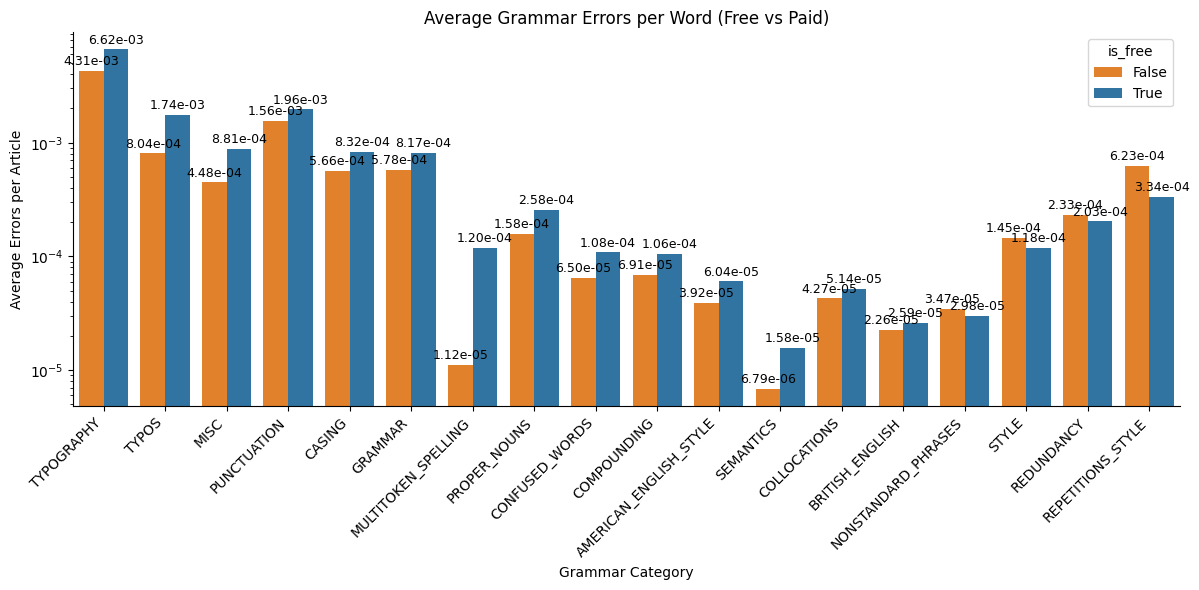

In [13]:
avg_errors = (
    norm_df.groupby('is_free')[grammar_columns]
    .mean()
    .T
    .reset_index()
    .melt(id_vars='index', var_name='is_free', value_name='Average Errors per Article')
)

avg_errors.rename(columns={'index': 'Grammar Category'}, inplace=True)

mean_diff = (
    normalized_summary.pivot(index='Grammar Category', columns='is_free', values='mean')
    .assign(diff=lambda df_: df_[True] - df_[False])
    .sort_values('diff', ascending=False)
)
sorted_categories = mean_diff.index.tolist()

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=avg_errors,
    x='Grammar Category',
    y='Average Errors per Article',
    hue='is_free',
    order=sorted_categories,
    palette=list(reversed(sns.color_palette(None, 2)))
)
plt.title('Average Grammar Errors per Word (Free vs Paid)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
sns.despine()

# --- Add labels on top of bars ---
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2e',           
        label_type='edge',    
        fontsize=9,
        padding=2
    )

plt.savefig(r'.\grammar_analysis\average_grammar_errors_per_word.png', dpi=300)
plt.show()
